# Python Implementation of "Room Segmentation in 3D Point Clouds Using Anisotropic Potential Fields"

### Author:
### Utku Turkbey     
* turkbey.utku@gmail.com
* [GitHub](https://github.com/uturkbey)
* [LinkedIn](https://www.linkedin.com/in/utku-turkbey-2213b018b/)

### ---------------------------------------------------------------------o---------------------------------------------------------------------
### About: 
This notebook includes the step by step Python implementation of the room segmentation pipeline proposed in the paper by D. Bobkov, M. Kiechle, S. Hilsenbeck, E. Steinbach "Room segmentation in 3D point clouds using anisotropic potential fields" presented at International Conference on Multimedia and Expo (ICME), Hong Kong, July 2017 [1]. 

Purpose of this work is to provide a proof-of-concept Python implementation for the proposed room segmentation pipeline in [1]. The code is not optimized for either computatational or space complexity. Some of the intermediate algorithms might be obtained partially or fully from other sources. Related references are provided when necessary. Same pipeline steps are fallowed as explained in the paper unless otherwise mentioned. The code is commented as much as possible to ease the work of a reader.  
### ---------------------------------------------------------------------o---------------------------------------------------------------------
### Abstract of the Paper: 
> "Emerging applications, such as indoor navigation or facility management, present new requirements of automatic and robust partitioning of indoor 3D point clouds into rooms. Previous research is either based on the Manhattan-world assumption or relies on the availability of the scanner pose information. We address these limitations by following the architectural definition of a room, where the room is an inner free space separated from other spaces through openings or partitions. For this we formulate an anisotropic potential field for 3D environments and illustrate how it can be used for room segmentation in the proposed segmentation pipeline. The experimental results confirm that our method outperforms state-of-the-art methods on a number of datasets including those that violate the Manhattan-world assumption." [1]
### ---------------------------------------------------------------------o---------------------------------------------------------------------
### For More Information About the Paper:
https://dbobkov.github.io/room-segmentation/
### ---------------------------------------------------------------------o---------------------------------------------------------------------
### References:
[1] D. Bobkov, M. Kiechle, S. Hilsenbeck and E. Steinbach, "Room segmentation in 3D point clouds using anisotropic potential fields," 2017 IEEE International Conference on Multimedia and Expo (ICME), 2017, pp. 727-732, doi: 10.1109/ICME.2017.8019484. URL: https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8019484&isnumber=8019290
        
[2] J. Straub, G. Rosman, O. Freifeld, J. J. Leonard and J. W. Fisher, "A Mixture of Manhattan Frames: Beyond the Manhattan World," 2014 IEEE Conference on Computer Vision and Pattern Recognition, 2014, pp. 3770-3777, doi: 10.1109/CVPR.2014.488. URL: https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=6909877&isnumber=6909393
    
[3] Y. Boykov and V. Kolmogorov, "An experimental comparison of min-cut/max- flow algorithms for energy minimization in vision," in IEEE Transactions on Pattern Analysis and Machine Intelligence, vol. 26, no. 9, pp. 1124-1137, Sept. 2004, doi: 10.1109/TPAMI.2004.60. URL: https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=1316848&isnumber=29188
    
[4] J. Jung, C. Stachniss, and C. Kim, “Automatic Room Segmentation of 3D Laser Data Using Morphological Processing,” ISPRS International Journal of Geo-Information, vol. 6, no. 7, p. 206, Jul. 2017, doi: 10.3390/ijgi6070206. URL: https://doi.org/10.3390/ijgi6070206
### ---------------------------------------------------------------------o---------------------------------------------------------------------
### Notebook Content:
1. [Pipeline Overview](#1)
2. [Used Packages](#2)<br>
    2.1 [Helper Functions](#2.1)
3. [Input Data](#3)
4. [Interior Free Space Classification](#4) <br>
    4.1. [Free vs. Busy Space Classification](#4.1) <br>
    4.2. [Interior vs. Exterior Space Classification](#4.2) <br>
    4.3. [Alternative Interior vs. Exterior Space Classification](#4.3)
5. [Anisotropic Potential Field Computation](#5)
6. [Clustering](#6)
7. [Mapping of Free Space Labelling to Busy Space](#7)

### ---------------------------------------------------------------------o---------------------------------------------------------------------

<a id='1'></a>
### 1. Pipeline Overview

The proposed room segmentation pipeline is neatly visualized with the figure below provided in [1].


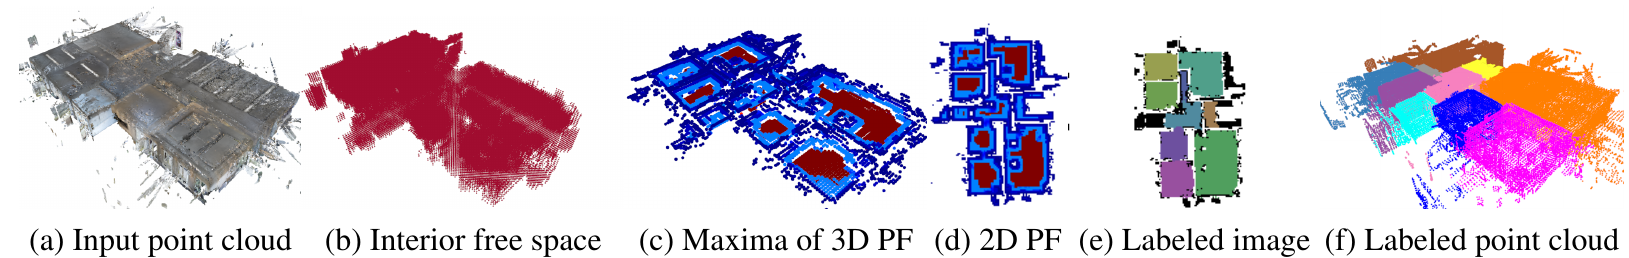

The authors of [1] summarize their pipeline with their own words as: 
> "We operate on a 3D point cloud (a) and start with detecting interior free space (b). We further proceed with computing a 3D anisotropic potential field (PF) for free voxels. Afterwards, we perform maxima detection in the PF values of each vertical voxel stack (c) and store the maximum value into a 2D PF map (d). Given the PF image, we perform clustering using information about the PF values as well as the visibility between voxels (e). Finally, we map the labeled free space back to the 3D point cloud (f)." [1]  

<a id='2'></a>
### 2. Used Packages
-Used packages for the implementation of the room segmentation pipeline are provided in the cell below.

In [1]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
import copy
import hdbscan

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


<a id='2.2'></a>
### 2.1 Helper Functions

In [2]:
def getAxes():
    #This functions returns a point cloud with colored points representing the X(Red),Y(Green),Z(Blue) axes.
    
    axes = o3d.geometry.PointCloud() #get an empty point cloud
    
    # manually define axes points (origin, x1, ..., x4, y1, ..., y4, z1, ... z4)
    np_points = np.zeros((13, 3))
    np_points[0] = [0,0,0]
    np_points[1] = [1,0,0] 
    np_points[2] = [2,0,0]
    np_points[3] = [3,0,0]
    np_points[4] = [4,0,0]
    np_points[5] = [0,1,0]
    np_points[6] = [0,2,0]
    np_points[7] = [0,3,0]
    np_points[8] = [0,4,0]
    np_points[9] = [0,0,1]
    np_points[10] = [0,0,2]
    np_points[11] = [0,0,3]
    np_points[12] = [0,0,4]

    #manually define axes colors (origin->black, X_axis->red, Y_axis->green, Z_axis->blue )
    np_colors = np.zeros((13, 3))
    np_colors[0] = [0,0,0];
    np_colors[1] = [1,0,0];
    np_colors[2] = [1,0,0];
    np_colors[3] = [1,0,0];
    np_colors[4] = [1,0,0];
    np_colors[5] = [0,1,0];
    np_colors[6] = [0,1,0];
    np_colors[7] = [0,1,0];
    np_colors[8] = [0,1,0];
    np_colors[9] = [0,0,1];
    np_colors[10] = [0,0,1];
    np_colors[11] = [0,0,1];
    np_colors[12] = [0,0,1];

    axes.points = o3d.utility.Vector3dVector(np_points)
    axes.colors = o3d.utility.Vector3dVector(np_colors)
    
    return axes

<a id='3'></a>
### 3. Input Data

-Input data is a 3D Point Cloud. Each point must have its position information encoded by a set of Cartesian coordinates (X, Y, Z). <br>
-No RGB/Intensity value or pose information is needed. <br>
-File format for the input data is assumed to be [Polygon File Format](http://paulbourke.net/dataformats/ply/)(_.ply_). It can be changed to any other suitable type . <br>

In [3]:
print(">>Load the input point cloud, calculate the bounding box, print and visualize(with axes). \n")
input_point_cloud = o3d.io.read_point_cloud(r".\multiRoom_input1.ply")
print(f"-Point cloud: {input_point_cloud}\n")
print(f"-Points in the cloud(X,Y,Z):\n{np.asarray(input_point_cloud.points)}\n")
aabb = input_point_cloud.get_axis_aligned_bounding_box()
aabb.color = [0,0,0]
print(f"-{aabb}")
axes = getAxes() #See 2.1 Helper Functions
#o3d.visualization.draw_geometries([input_point_cloud, aabb, axes])

>>Load the input point cloud, calculate the bounding box, print and visualize(with axes). 

-Point cloud: PointCloud with 339372 points.

-Points in the cloud(X,Y,Z):
[[ 4.94318962 -0.28139997  0.62947655]
 [ 7.40890169 -1.20943117  1.76394677]
 [-2.36834908 -1.34182632  2.68782687]
 ...
 [ 7.51455736  1.16042006  4.32707548]
 [ 3.06914258  0.41569203  2.48672366]
 [-2.76160002  0.84416002  1.93692887]]

-AxisAlignedBoundingBox: min: (-6.13429, -1.66451, -0.813977), max: (13.6245, 1.29454, 6.23765)


<a id='4'></a>
### 4. Interior Free Space Classification

-This block of the pipeline takes _input_point_cloud_ as the input. <br>
-(4.1)First, the space spanned by the bounding box of the point cloud is voxelized and the voxels are classified as free and busy. Isolated busy voxels are freed. <br>
-(4.2)Then, to identify the interior space, a simlified Markov Random Field formulation based on enclosing of the free voxels is proposed and solved using graphcuts.    

<a id='4.1'></a>
### 4.1. Free vs. Busy Space Classification

__Steps:__
* Voxelize the space spanned by the bounding box.
* Classify the voxels as busy of free.
* Free vertically enclosed busy voxels.

__Inputs:__
* _input_point_cloud_: 3D point cloud data
* v_ratio: User defined ratio parameter to determine the voxel size(v_size) based on the longest edge of the bounding box

__Outputs:__
* _free_voxels_: int type 3D _numpy.ndarray_ holding the free vs busy information of the voxels (dense). Free Voxels -> 0, Busy Voxels -> 1
* _voxel_grid_: Voxel grid created from the _input_point_cloud_

__General Comments:__
* -

__Comments on testing:__
* Algortihm below is tested with synthetic "axes" point cloud created by helper function _getAxes()_.
* Number of voxels calculated is checked. Built-in _o3d.geometry.VoxelGrid.create_from_point_cloud(...)_ starts partitioning the space by inserting a voxel centered at the minimum bound of the point cloud. Then continues by inserting full voxels until the upper bound and add an extra voxel if any space less then the voxel size is left. Therefore add 1 extra in each dimension to v_number=max_range/v_size.
* Created _free_voxels_ matrix is checked.
* _free_voxels_ matrix after freeing the isolated busy voxels is checked. Freeing mechanism works.
    
__Comments on efficiency:__
* Free check algorithm might be improved by: 
    * 1)Adding a mechanishm to skip the next 4 voxels in vertical stack since after freeing next 3 voxels will be free for sure.
    * 2)Rearranging the order or _if_ statements. (Not sure if a better order exists.)

In [4]:
#User defined ratio to determine voxel size
v_ratio = 0.009

#Determine the voxel size based on the longest edge of the bounding box and a constant ratio. Use 4 decimal point precision.
v_size=round(max(input_point_cloud.get_max_bound()-input_point_cloud.get_min_bound())*v_ratio, 4)  
v_number= (input_point_cloud.get_max_bound()-input_point_cloud.get_min_bound())/v_size
v_number[0], v_number[1], v_number[2] = round(v_number[0])+1, round(v_number[1])+1, round(v_number[2])+1 #+1 due to the calculation of voxel_grid
v_number = v_number.astype(int)

#Create a voxel grid with voxels for each subspace of the point cloud with at least one data point.   
voxel_grid=o3d.geometry.VoxelGrid.create_from_point_cloud(input_point_cloud,voxel_size=v_size)

#Transfer busy vs. free information from voxel grid to a 3D 'np.array'. 
free_voxels = np.zeros((v_number[0], v_number[1], v_number[2]), dtype=int) 
for voxel in voxel_grid.get_voxels():
    free_voxels[voxel.grid_index[0]][voxel.grid_index[1]][voxel.grid_index[2]] = 1 #Busy_Voxel->1 (Free_Voxel->0) 
    
#Free the isolated busy voxels (old version)
#for x in range(v_number[0]):
#    for z in range(v_number[2]):
#        vertical_stack = free_voxels[x].T[z]
#        for y in range(v_number[1]):
#            if vertical_stack[y] == 1: #if a voxel is busy
#                if y < len(vertical_stack)-4 and vertical_stack[y+1] == 0 and vertical_stack[y+2] == 1 and vertical_stack[y+3] == 0 and vertical_stack[y+4] == 1:
#                    vertical_stack[y+2] = 0; #free the isolated voxel

#Free the isolated busy voxels (new version)
for plane in free_voxels: #get planes orthogonal to X-axis
    for vertical_stack in plane.T: #get vertical stacks parallel to Y-axis
        for y in range(v_number[1]):
            if vertical_stack[y] == 1: #if a voxel is busy
                if y < len(vertical_stack)-4 and vertical_stack[y+1] == 0 and vertical_stack[y+2] == 1 and vertical_stack[y+3] == 0 and vertical_stack[y+4] == 1:
                    vertical_stack[y+2] = 0; #free the isolated voxel

In [5]:
#o3d.visualization.draw_geometries([voxel_grid, aabb, axes])

<a id='4.2'></a>

### 4.2. Interior vs. Exterior Space Classification
__Steps:__
* Apply _Mixture of Manhattan Frames Algorithm_[2] to calculate the two dominant directions of free voxels to check enclosing.
* Calculate evidence _E(v)_ for each free voxel.
* Build a 6-neighorhood connected graph spanning all free voxels.
* Compute graphcut by using _Boykov-Kolmogorov Mincut Algorithm_[3] to detect interior free voxels.

__Inputs:__

__Outputs:__

__General Comments:__
* To be implemented later.

__Comments on testing:__

__Comments on efficiency:__

In [6]:
#Apply Mixture of Manhattan Frames

#Calculate E(v)
    
#Build a connected graph
    
#Compute graphcut 


<a id='4.3'></a>

### 4.3. Alternative Interior vs. Exterior Space Classification

Inspired from another room segmentation approach in [4].

__Steps:__
* Compute a histogram over busy voxels along the Y-axis to see the height variations. Pick the heights of the two peaks in histogram to be the floor and ceiling heights.  
* Mark all the voxels below/above these heights and outside the region defined by the XZ projection of the ceiling and floor as exterior. (Including the busy voxels. This also denoises the data by removing outliers.) Remainnig pixels are assumed to be the interior free voxels.

__Inputs:__
* _free_voxels_: int type 3D _numpy.ndarray_ holding the free vs busy information of the voxels(dense). Interior Free Voxels -> 0, Other Voxels -> 1 
* _voxel_grid_: Voxel grid created from the _input_point_cloud_ <br>

__Outputs:__
* _free_voxels_: int 3D _numpy.ndarray_ holding the information of the interior free voxels vs others (dense). <br> Interior Free Voxels -> 0, <br> Busy Voxels -> 1, <br>Exterior Free Voxels -> 2 <br>

__General Comments:__
* This algorithm does not perform well with every type of scan(e.g. curved ceilings). Needs to be improved!! Check the depth images approach. 

__Comments on testing:__
* Manually tested with simple input point cloud data. Works fine.

__Comments on efficiency:__
* Might be combined with voxel freeing in section 4.1 to obtain the same results with a single pass.

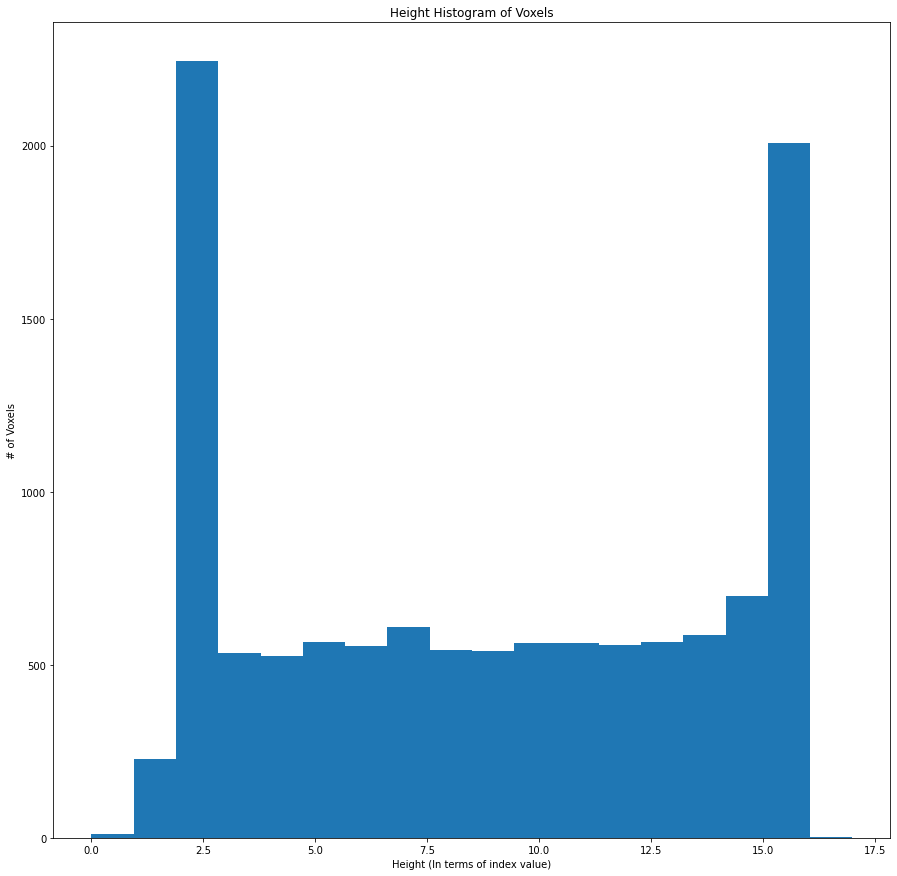

In [7]:
#Compute the histogram over busy voxels along the Y-axis
heights = [voxel.grid_index[1] for voxel in voxel_grid.get_voxels()]
plt.figure(figsize=(15, 15))
hist = plt.hist(heights, v_number[1])
plt.title("Height Histogram of Voxels")
plt.xlabel("Height (In terms of index value)")
plt.ylabel("# of Voxels")
plt.show()

#Select the two peak heights, min of them is floor height and max of them is ceiling height
peak_height1 = int(hist[1][np.argmax(hist[0])+1])
peak_height2 = int(hist[1][np.where(hist[0]==np.partition(hist[0], -2)[-2])][0])
floor = min(peak_height1, peak_height2)
ceiling = max(peak_height1, peak_height2)

#Detect exterior free voxels.
for plane in free_voxels: #get planes orthogonal to X-axis
    for vertical_stack in plane.T: #get vertical stacks parallel to Y-axis
        if vertical_stack[floor]==0 and vertical_stack[ceiling]==0: #if the voxels are not in the region defined by the projection of ceiling and floor
            for y in range(v_number[1]):
                    vertical_stack[y] = 2
        else: #if the voxels are below or above the ceiling heights
            for y in range(v_number[1]):
                if y < floor:
                    vertical_stack[y] = 2
                if y > ceiling:
                    vertical_stack[y] = 2           

<a id='5'></a>
### 5. Anisotropic Potential Field Computation

__Steps:__
* For every free voxel, perform nearest neighbor search in the halfspace spanning the positive Y-direction. This way, every voxel stores the L2-distance to the closest busy voxel lying in the half-space spanning positive Y values, so called anisotropic potential field (PF) value. Record it to _pf_3D_.
* Project _pf_3D_ data to XZ-plane by choosing the maximum values over each vertical stack in Y-axes. Record it to _pf_2D_.
* Check visibility between every max value voxel and the ceiling voxel for each vertical stack in Y-direction. Record it to _visib_map_.

__Inputs:__
* _free_voxels_: int 3D _numpy.ndarray_ holding the information of the interior free voxels vs others (dense). <br> Interior Free Voxels -> 0, <br> Busy Voxels -> 1, <br>Exterior Free Voxels -> 2 <br>
* _voxel_grid_: Voxel grid created from the _input_point_cloud_ <br>

__Outputs:__
* _pf_2D_: flaot 2D _numpy.ndarray_ of PF(dense).
* _pf_3D_: flaot 3D _numpy.ndarray_ of PF(dense).
* _visib_map_: flaot 2D _numpy.ndarray_ of visibility map(dense).

__General Comments:__
* __Visibility calculation is missing.__

__Comments on testing:__
*  Manually tested with one single room and one multiple room input point cloud data. Outlier points which cannnot be filtered during the interior vs exterior classification is reflected on the PF maps as expected. PF distribuitons seems reasonable.  

__Comments on efficiency:__
* Calculation of L2 norms from each pixel to every busy voxel in the above halfspace is computationally heavy compared to the rest of the pipeline. Needs improvement in the future. 
* Calculating distances for all points in the same plane perpendicular to Y-axis and then choose the min distances for each free voxel might be a strategy. However memory requirements increases and computation load might not be decreased. 
* Alternatively, KDTree might be used but building tree for each halfspace might be computationally heavy. 

In [8]:
#Define necessary arrays to store data
pf_2D = np.zeros((v_number[0], v_number[2]))
pf_3D = np.zeros((v_number[0], v_number[1], v_number[2]))
visib_map = np.zeros((v_number[0], v_number[2])) #Not being used currently

#Find the L2(euclidian) norm to nearest neighbor of every free voxel. Start from the free voxels lying in 
#the lowest(in terms of Y coords.) plane parallel to XZ-plane. Then continue with the other voxels in 
#upper planes(in terms of Y coord). By doing so, use the list of busy voxels in the halfspace spanning the positive Y-direction. 

i = 0 #to trace Y level
for plane in np.moveaxis(free_voxels, 0, 1): #Each plane is vertical to Y-axis
    #Select busy voxels in the halfspace spanning the positive Y-direction wrt. the Y level of current plane.
    busy_voxels = np.asarray([voxel.grid_index for voxel in voxel_grid.get_voxels() if voxel.grid_index[1]>=i])
    for x in range(v_number[0]):
        for z in range(v_number[2]):
            if plane[x][z] == 0:
                pf_3D[x][i][z] = min(distance.cdist(busy_voxels, np.array([[x,i,z]]), 'euclidean'))[0]
    i = i + 1 #increase y to trace Y level of current planes             

#project pf_3D to XZ-plane (Will result in a dense array with many zero PF valued voxels)
for x in range(v_number[0]):
    for z in range(v_number[2]):
        y_index_of_max = np.argmax(pf_3D[x].T[z]) #find index of maximum along a vertical stack
        pf_2D[x][z]= pf_3D[x][y_index_of_max][z] #project the maximum to XZ-plane

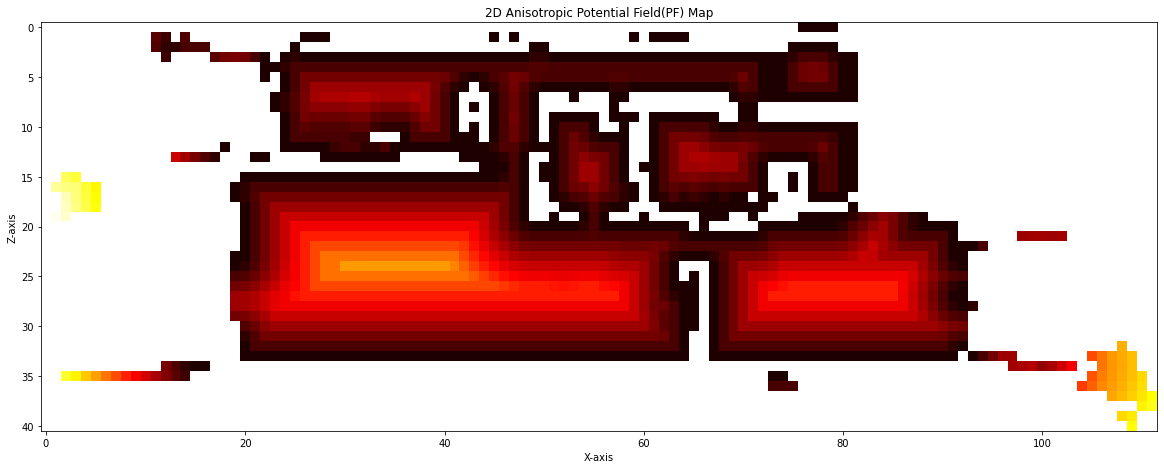

In [9]:
#Plot the 2D PF Map (only for the free voxels with PF values)
cmap = copy.copy(plt.get_cmap('hot'))
cmap.set_under('white')
plt.figure(figsize=(20, 20))
plt.imshow(pf_2D.T, cmap=cmap, vmin=0.5)
plt.title("2D Anisotropic Potential Field(PF) Map")
plt.xlabel("X-axis")
plt.ylabel("Z-axis")
plt.show()

<a id='6'></a>
### 6. Clustering

__Steps:__
* Define the weights to be used for Difference Matrix calculation.
* Obtain the sparse represantation of (free interior) voxels.
* Calculate the Difference Matrix D for every voxel with the .
* Apply HDBSCAN algorithm to cluster rooms.
* Obtain the dense map of clustered free voxels.

__Inputs:__
* _pf_2D_: flaot 2D _numpy.ndarray_ of PF (dense).

__Outputs:__
* _clustered_: int 2D _numpy.ndarray_ of clustered voxels (dense). 

__General Comments:__
* Visibility information is not used during D calculation.
* !!!Clustering does not segment rooms.
* Try to adopt local maxima detection step before clustering.

__Comments on testing:__
* Tested with a multiple room scan. For small values of _w_pf_, exterior vs interior clustering occurs. For large values of _w_pf_, over segmentation occurs. Clustering does not segment rooms

__Comments on efficiency:__
* Creating a an empty list to store free voxels and appending it every time might be inefficient. Improvement might be usefull.

In [18]:
#Weights of distances
w_euc = 0.6
w_pf = 1 # If visibility info not used, threshold value for 5 to 50 labels discontinouos jump is 3.90554 -> 3.90555.

#Get the voxels to be clustered
#(From dense array with many zero PF valued voxels to a list of actual voxels representing imterior free space)
voxels = list()
for x in range(pf_2D.shape[0]):
    for z in range(pf_2D.shape[1]):
        if pf_2D[x][z] != 0:
            voxels.append((x,z,pf_2D[x][z]))        

#Define difference matrix D
D = np.zeros((len(voxels),len(voxels)))

#Calculate difference matrix D (Only the upper triangle part)           
for i in range(len(voxels)):
    for j in range(i, len(voxels)):
        x_i = voxels[i][0]
        z_i = voxels[i][1] 
        x_j = voxels[j][0]
        z_j = voxels[j][1]
        D[i][j] = (((x_i-x_j)**2 + (z_i-z_j)**2 )**0.5)*w_euc + abs(voxels[i][2]-voxels[j][2])*w_pf
D = D + D.T #Define lower triangle as the symetric of the upper triangle

#Cluster voxels using HDBSCAN module
clusterer = hdbscan.HDBSCAN(metric='precomputed')
clusterer.fit(D)

#Obtain the Dense Map of clustered voxels.
clustered = np.zeros((v_number[0], v_number[2]))
clustered = clustered.astype(int)

for index in range(len(voxels)):
    clustered[voxels[index][0]][voxels[index][1]] = clusterer.labels_[index]+1

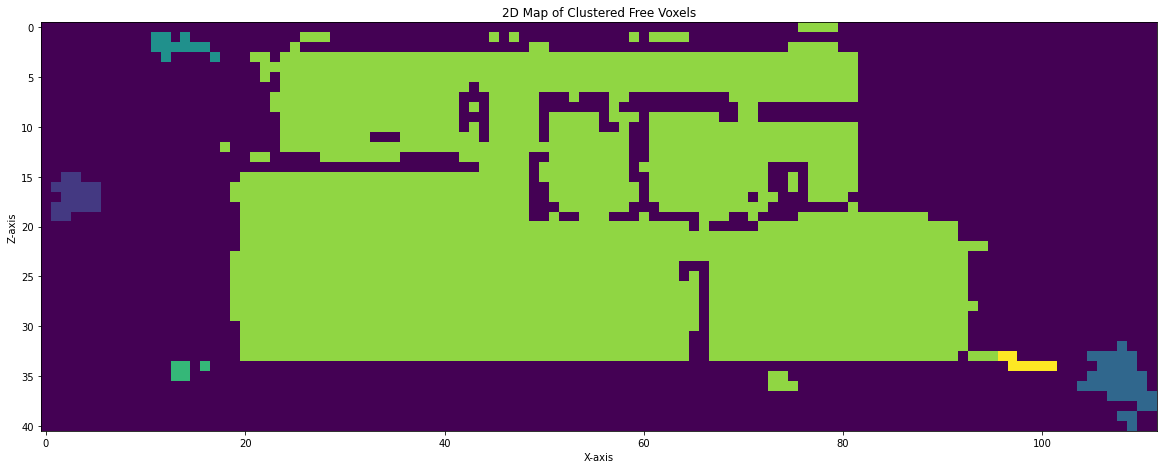

In [19]:
#Plot the 2D map of clustered free voxels.
plt.figure(figsize=(20, 20))
plt.imshow(clustered.T)
plt.title("2D Map of Clustered Free Voxels")
plt.xlabel("X-axis")
plt.ylabel("Z-axis")
plt.show()

<a id='7'></a>
### 7. Mapping of Free Space Labelling to Busy Space